In [4]:
!pip install -q --upgrade scipy==1.10.1 albumentations==1.3.1


In [1]:
import torch
import torchvision
import cv2
import numpy as np
import albumentations as A
from skimage import io
import pandas as pd

print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("OpenCV:", cv2.__version__)
print("Albumentations:", A.__version__)


Torch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
OpenCV: 4.12.0
Albumentations: 2.0.8


In [2]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0)) 

CUDA Available: True
GPU Name: Tesla P100-PCIE-16GB


In [3]:
x = torch.randn(2, 3, 224, 224).cuda()
y = x * 2
print("Tensor on GPU successful:", y.device) 

Tensor on GPU successful: cuda:0


In [4]:
import os

DATA_ROOT = "/kaggle/input/landmarks"
IMG_DIR = os.path.join(DATA_ROOT, "images-20251228T061414Z-3-001", "images")
CSV_PATH = os.path.join(DATA_ROOT, "/kaggle/input/landmarks/role_challenge_dataset_ground_truth.csv")

print("Images path:", IMG_DIR)
print("CSV path:", CSV_PATH)
print("Total images:", len(os.listdir(IMG_DIR)))


Images path: /kaggle/input/landmarks/images-20251228T061414Z-3-001/images
CSV path: /kaggle/input/landmarks/role_challenge_dataset_ground_truth.csv
Total images: 622


In [5]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
print("Rows:", len(df))
df.head()

Rows: 622


,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,361,12,339,530,481,16,664,318
1,001_HC.png,441,331,368,308,297,247,534,142
2,002_HC.png,318,374,154,406,481,158,558,215
3,003_HC.png,424,105,407,462,305,349,547,363
4,004_HC.png,300,277,611,534,53,452,494,308


In [6]:
image_files = set(os.listdir(IMG_DIR))
csv_images = set(df['image_name'])

print("Images in folder:", len(image_files))
print("Images in CSV:", len(csv_images))
print("Missing in folder:", len(csv_images - image_files))
print("Extra in folder:", len(image_files - csv_images))


Images in folder: 622
Images in CSV: 622
Missing in folder: 0
Extra in folder: 0


Image shape: (540, 800)


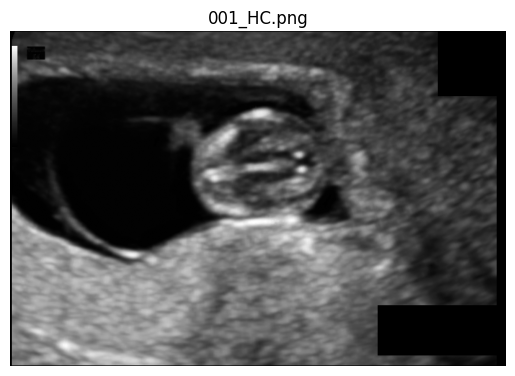

In [7]:
import cv2
import matplotlib.pyplot as plt

sample_name = df.iloc[1]['image_name']
img_path = os.path.join(IMG_DIR, sample_name)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

print("Image shape:", img.shape)

plt.imshow(img, cmap='gray')
plt.title(sample_name)
plt.axis('off')
plt.show()


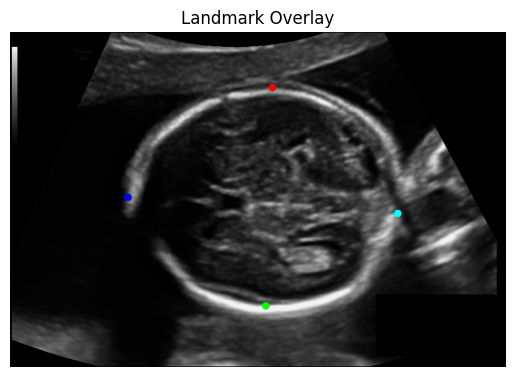

In [8]:
import random

row = df.sample(5).iloc[0]
img_path = os.path.join(IMG_DIR, row['image_name'])
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

pts = [
    (row['ofd_1_x'], row['ofd_1_y']),
    (row['ofd_2_x'], row['ofd_2_y']),
    (row['bpd_1_x'], row['bpd_1_y']),
    (row['bpd_2_x'], row['bpd_2_y'])
]

img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

colors = [(0,0,255),(0,255,0),(255,0,0),(255,255,0)]

for p,c in zip(pts, colors):
    cv2.circle(img_color, (int(p[0]), int(p[1])), 6, c, -1)

plt.imshow(img_color[...,::-1])
plt.title("Landmark Overlay")
plt.axis('off')
plt.show()


In [9]:
h, w = img.shape
bad_points = []

for _, r in df.iterrows():
    pts = [
        (r['ofd_1_x'], r['ofd_1_y']),
        (r['ofd_2_x'], r['ofd_2_y']),
        (r['bpd_1_x'], r['bpd_1_y']),
        (r['bpd_2_x'], r['bpd_2_y'])
    ]
    for x,y in pts:
        if x < 0 or y < 0 or x >= w or y >= h:
            bad_points.append(r['image_name'])

print("Images with invalid coords:", len(bad_points))
bad_points[:10]


Images with invalid coords: 0


[]

step 4


In [10]:
IMG_SIZE = 256        
NUM_LANDMARKS = 4     
HEATMAP_SIZE = 256    
GAUSSIAN_RADIUS = 4

In [11]:
import numpy as np
import cv2

def generate_heatmap(h, w, x, y, radius=4):
    heatmap = np.zeros((h, w), dtype=np.float32)
    
    x = int(x)
    y = int(y)

    if x < 0 or y < 0 or x >= w or y >= h:
        return heatmap  
    
    cv2.circle(heatmap, (x, y), radius, 1.0, -1)
    heatmap = cv2.GaussianBlur(heatmap, (0,0), sigmaX=radius, sigmaY=radius)
    heatmap = heatmap / heatmap.max() if heatmap.max() > 0 else heatmap
    return heatmap

In [12]:
def resize_with_landmarks(img, landmarks):
    h, w = img.shape[:2]

    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    scale_x = IMG_SIZE / w
    scale_y = IMG_SIZE / h

    scaled = []
    for x, y in landmarks:
        scaled.append((x * scale_x, y * scale_y))

    return img_resized, scaled


In [13]:
train_augs = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                       rotate_limit=10, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
], keypoint_params=A.KeypointParams(format='xy'))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [14]:
import torch
from torch.utils.data import Dataset

class FetalLandmarkDataset(Dataset):
    def __init__(self, df, img_dir, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            img_path = os.path.join(self.img_dir, row['image_name'])

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError("Image failed to load")

            landmarks = [
                (row['ofd_1_x'], row['ofd_1_y']),
                (row['ofd_2_x'], row['ofd_2_y']),
                (row['bpd_1_x'], row['bpd_1_y']),
                (row['bpd_2_x'], row['bpd_2_y'])
            ]

            if self.augment:
                augmented = train_augs(image=img, keypoints=landmarks)
                img = augmented['image']
                landmarks = augmented['keypoints']

            img, landmarks = resize_with_landmarks(img, landmarks)
            img = np.ascontiguousarray(img).astype(np.float32) / 255.0

            img = np.stack([img, img, img], axis=0)

     
            landmarks = list(landmarks)

            if len(landmarks) > 4:
                landmarks = landmarks[:4]

            while len(landmarks) < 4:
                landmarks.append((None, None))

            heatmaps = []
            for (x, y) in landmarks:
                if (
                    x is None or y is None or
                    np.isnan(x) or np.isnan(y)
                ):
                    hm = np.zeros((HEATMAP_SIZE, HEATMAP_SIZE), dtype=np.float32)
                else:
                    hm = generate_heatmap(
                        HEATMAP_SIZE,
                        HEATMAP_SIZE,
                        int(x),
                        int(y),
                        GAUSSIAN_RADIUS
                    )
                heatmaps.append(hm)

            heatmaps = np.stack(heatmaps, axis=0).astype(np.float32)
            heatmaps = np.ascontiguousarray(heatmaps)

            return (
                torch.from_numpy(img.copy()).float(),
                torch.from_numpy(heatmaps.copy()).float()
            )

        except Exception as e:
            print("BAD SAMPLE:", idx, self.df.iloc[idx]['image_name'], e)

            dummy_img = np.zeros((3, 256, 256), dtype=np.float32)
            dummy_hm  = np.zeros((4, 256, 256), dtype=np.float32)

            return (
                torch.from_numpy(dummy_img).float(),
                torch.from_numpy(dummy_hm).float()
            )


In [15]:
sample_img, sample_hm = FetalLandmarkDataset(df, IMG_DIR, augment=True)[10]

print("Image shape:", sample_img.shape)
print("Heatmap shape:", sample_hm.shape)

Image shape: torch.Size([3, 256, 256])
Heatmap shape: torch.Size([4, 256, 256])


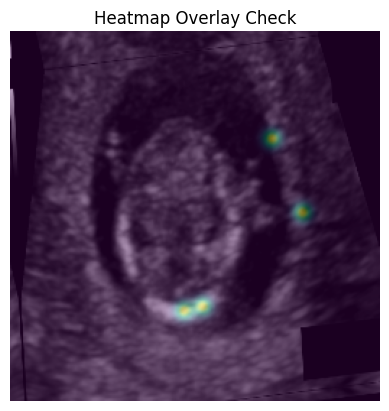

In [16]:
import matplotlib.pyplot as plt

img = sample_img.numpy().transpose(1,2,0)
hm_sum = sample_hm.numpy().sum(axis=0)

plt.imshow(img[...,0], cmap='gray')
plt.imshow(hm_sum, alpha=0.4)
plt.axis('off')
plt.title("Heatmap Overlay Check")
plt.show()


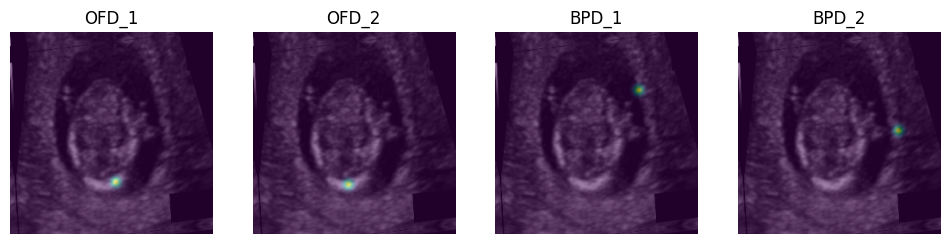

In [17]:
import matplotlib.pyplot as plt

img = sample_img.numpy().transpose(1,2,0)[...,0]

fig, axs = plt.subplots(1,4, figsize=(12,3))
titles = ["OFD_1","OFD_2","BPD_1","BPD_2"]

for i in range(4):
    axs[i].imshow(img, cmap='gray')
    axs[i].imshow(sample_hm[i].numpy(), alpha=0.5)
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.show()


step 5

In [18]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        self.skip = nn.Conv2d(in_ch, out_ch, 1, bias=False)

    def forward(self, x):
        return torch.relu(self.conv(x) + self.skip(x))


In [19]:
class DownSample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvBlock(ch, ch)

    def forward(self, x):
        return self.conv(self.pool(x))


class UpSample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = ConvBlock(ch, ch)

    def forward(self, x):
        return self.conv(self.up(x))


In [20]:
class Hourglass(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth
        self.channels = channels

        self.res = ConvBlock(channels, channels)

        if depth > 1:
            self.down = DownSample(channels)
            self.inner = Hourglass(depth-1, channels)
            self.up = UpSample(channels)
        else:
            self.inner_res = ConvBlock(channels, channels)

    def forward(self, x):
        up1 = self.res(x)

        if self.depth > 1:
            low = self.down(x)
            low = self.inner(low)
            low = self.up(low)
        else:
            low = self.inner_res(x)

        return up1 + low


In [21]:
class HeatmapHead(nn.Module):
    def __init__(self, ch, num_landmarks):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(ch, num_landmarks, 1)
        )

    def forward(self, x):
        return self.head(x)


In [22]:
class HourglassNet(nn.Module):
    def __init__(self, num_landmarks=4, channels=64, depth=4):
        super().__init__()

        self.pre = nn.Sequential(
            ConvBlock(3, channels),
            ConvBlock(channels, channels)
        )

        self.hourglass = Hourglass(depth, channels)
        self.head = HeatmapHead(channels, num_landmarks)

    def forward(self, x):
        x = self.pre(x)
        x = self.hourglass(x)
        x = self.head(x)
        return x  

step 6

In [23]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

len(train_df), len(val_df)

(528, 94)

In [24]:
from torch.utils.data import DataLoader

train_dataset = FetalLandmarkDataset(train_df, IMG_DIR, augment=True)
val_dataset   = FetalLandmarkDataset(val_df, IMG_DIR, augment=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 66
Val batches: 12


In [25]:
import torch.nn.functional as F

def heatmap_loss(pred, target):
    return F.mse_loss(pred, target)

In [26]:
model = HourglassNet(num_landmarks=4).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
)

In [27]:
current_lr = optimizer.param_groups[0]['lr']
print(f"Current LR: {current_lr:.6f}")

Current LR: 0.001000


In [28]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0

    for imgs, heatmaps in loader:
        imgs = imgs.cuda()
        heatmaps = heatmaps.cuda()

        optimizer.zero_grad()

        preds = model(imgs)

        loss = heatmap_loss(preds, heatmaps)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [29]:
@torch.no_grad()
def validate(model, loader):
    model.eval()
    total_loss = 0

    for imgs, heatmaps in loader:
        imgs = imgs.cuda()
        heatmaps = heatmaps.cuda()

        preds = model(imgs)
        loss = heatmap_loss(preds, heatmaps)   

        total_loss += loss.item()

    return total_loss / len(loader)


In [34]:
import time

EPOCHS = 80
best_val = float('inf')

for epoch in range(1, EPOCHS+1):
    t0 = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)

    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | Train {train_loss:.4f} | Val {val_loss:.4f} | Time {(time.time()-t0):.1f}s")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "/kaggle/working/best_hourglass.pth")
        print("Saved new best model.") 

Epoch 01 | Train 0.0102 | Val 0.0011 | Time 25.2s
Saved new best model.
Epoch 02 | Train 0.0010 | Val 0.0010 | Time 21.1s
Saved new best model.
Epoch 03 | Train 0.0010 | Val 0.0010 | Time 21.1s
Saved new best model.
Epoch 04 | Train 0.0010 | Val 0.0010 | Time 21.1s
Saved new best model.
Epoch 05 | Train 0.0010 | Val 0.0010 | Time 21.0s
Saved new best model.
Epoch 06 | Train 0.0010 | Val 0.0010 | Time 21.0s
Saved new best model.
Epoch 07 | Train 0.0010 | Val 0.0010 | Time 21.0s
Saved new best model.
Epoch 08 | Train 0.0009 | Val 0.0009 | Time 21.1s
Saved new best model.
Epoch 09 | Train 0.0009 | Val 0.0009 | Time 21.0s
Saved new best model.
Epoch 10 | Train 0.0009 | Val 0.0009 | Time 21.0s
Saved new best model.
Epoch 11 | Train 0.0009 | Val 0.0009 | Time 21.0s
Saved new best model.
Epoch 12 | Train 0.0009 | Val 0.0009 | Time 20.9s
Saved new best model.
Epoch 13 | Train 0.0009 | Val 0.0009 | Time 21.0s
Epoch 14 | Train 0.0009 | Val 0.0009 | Time 21.0s
Saved new best model.
Epoch 15 | Tra

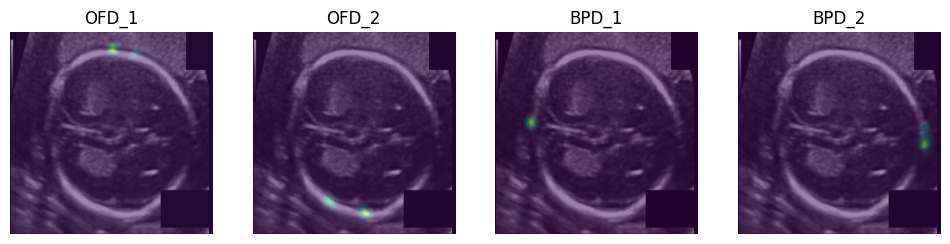

In [35]:
@torch.no_grad()
def visualize_predictions():
    model.eval()

    imgs, hms = next(iter(val_loader))
    imgs = imgs.cuda()

    preds = model(imgs).cpu().numpy()
    pred_hm = preds[0]


    img = imgs[0].cpu().numpy().transpose(1,2,0)[...,0]
    pred_hm = preds[0]           

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 4, figsize=(12,3))

    titles = ["OFD_1","OFD_2","BPD_1","BPD_2"]

    for i in range(4):
        axs[i].imshow(img, cmap='gray')
        axs[i].imshow(pred_hm[i], alpha=0.5)
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    plt.show()

visualize_predictions()


In [36]:
import torch
import numpy as np

def heatmap_to_coords(hm):
    # hm: (4, H, W)
    coords = []
    for i in range(hm.shape[0]):
        y, x = np.unravel_index(hm[i].argmax(), hm[i].shape)
        coords.append((x, y))
    return coords


@torch.no_grad()
def evaluate_pixel_error(n=20):
    model.eval()
    errors = []

    for i, (imgs, hms) in enumerate(val_loader):
        if i >= n:
            break

        imgs = imgs.cuda()

        preds = model(imgs).cpu().numpy()


        gts = hms.numpy()

        pred_xy = heatmap_to_coords(preds[0])
        gt_xy   = heatmap_to_coords(gts[0])

        for p, g in zip(pred_xy, gt_xy):
            dist = np.linalg.norm(np.array(p) - np.array(g))
            errors.append(dist)

    print("Mean pixel error:", np.mean(errors))
    print("Median pixel error:", np.median(errors))

evaluate_pixel_error()

Mean pixel error: 23.767048023734294
Median pixel error: 4.611062569605222


In [37]:
torch.save(model.state_dict(), "hourglass_single.pth")